![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.Clinical_Named_Entity_Recognition_Model.ipynb)

# Clinical Named Entity Recognition (NER)

##  1. NER Model Implementation in Spark NLP

  The deep neural network architecture for NER model in
Spark NLP is BiLSTM-CNN-Char framework. a slightly modified version of the architecture proposed by Jason PC Chiu and Eric Nichols ([Named Entity Recognition with Bidirectional LSTM-CNNs
](https://arxiv.org/abs/1511.08308)). It is a neural network architecture that
automatically detects word and character-level features using a
hybrid bidirectional LSTM and CNN architecture, eliminating
the need for most feature engineering steps.

  In the original framework, the CNN extracts a fixed length
feature vector from character-level features. For each word,
these vectors are concatenated and fed to the BLSTM network
and then to the output layers. They employed a stacked
bi-directional recurrent neural network with long short-term
memory units to transform word features into named entity
tag scores. The extracted features of each word are fed into a
forward LSTM network and a backward LSTM network. The
output of each network at each time step is decoded by a linear
layer and a log-softmax layer into log-probabilities for each tag
category. These two vectors are then simply added together to
produce the final output. In the architecture of the proposed framework in the original paper, 50-dimensional pretrained word
embeddings is used for word features, 25-dimension character
embeddings is used for char features, and capitalization features
(allCaps, upperInitial, lowercase, mixedCaps, noinfo) are used
for case features.

## 2. Blogposts and videos:

- [How to Setup Spark NLP for HEALTHCARE on UBUNTU - Video](https://www.youtube.com/watch?v=yKnF-_oz0GE)

- [Named Entity Recognition (NER) with BERT in Spark NLP](https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77)

- [State of the art Clinical Named Entity Recognition in Spark NLP - Youtube](https://www.youtube.com/watch?v=YM-e4eOiQ34)

- [Named Entity Recognition for Healthcare with SparkNLP NerDL and NerCRF](https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571)

- [Named Entity Recognition for Clinical Text](https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180)

## 3. Colab Setup

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

In [ ]:
license_keys.keys()

In [ ]:
license_keys['JSL_VERSION']

In [ ]:
license_keys['PUBLIC_VERSION']

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [ ]:
import json
import os
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl
import sparknlp

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G", 
          "spark.kryoserializer.buffer.max":"2000M", 
          "spark.driver.maxResultSize":"2000M"} 

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

In [ ]:
# if you want to start the session with custom params as in start function above
from pyspark.sql import SparkSession

def start(SECRET):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:"+PUBLIC_VERSION) \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+SECRET+"/spark-nlp-jsl-"+JSL_VERSION+".jar")
      
    return builder.getOrCreate()

#spark = start(SECRET)

## 4. Clinical NER Pipeline (with pretrained models)

- **Clinical NER Models**

|   index | model_name                     |   index | model_name                        |   index | model_name                        |   index | model_name                 |
|--------:|:-------------------------------|--------:|:----------------------------------|--------:|:----------------------------------|--------:|:---------------------------|
|       1 | jsl_ner_wip_clinical           |      17 | ner_chexpert                      |      33 | ner_deid_subentity (German)       |      49 | ner_jsl_greedy             |
|       2 | jsl_ner_wip_greedy_clinical    |      18 | ner_clinical                      |      34 | ner_diseases_large                |      50 | ner_jsl_slim               |
|       3 | jsl_ner_wip_modifier_clinical  |      19 | ner_clinical_icdem                |      35 | ner_drugs                         |      51 | ner_measurements_clinical  |
|       4 | jsl_rd_ner_wip_greedy_clinical |      20 | ner_clinical_large                |      36 | ner_drugs_greedy                  |      52 | ner_medmentions_coarse     |
|       5 | ner_ade_clinical               |      21 | ner_clinical_large_en             |      37 | ner_drugs_large                   |      53 | ner_posology               |
|       6 | ner_ade_clinicalbert           |      22 | ner_deid_augmented                |      38 | ner_events_admission_clinical     |      54 | ner_posology_experimental  |
|       7 | ner_ade_healthcare             |      23 | ner_deid_enriched                 |      39 | ner_events_clinical               |      55 | ner_posology_greedy        |
|       8 | ner_anatomy                    |      24 | ner_deid_generic_augmented        |      40 | ner_events_healthcare             |      56 | ner_posology_healthcare    |
|       9 | ner_anatomy_coarse             |      25 | ner_deid_generic (German)         |      41 | ner_genetic_variants              |      57 | ner_posology_large         |
|      10 | ner_bacterial_species          |      26 | ner_deid_large                    |      42 | ner_healthcare                    |      58 | ner_posology_small         |
|      11 | ner_bionlp                     |      27 | ner_deid_sd                       |      43 | ner_human_phenotype_gene_clinical |      59 | ner_profiling_clinical     |
|      12 | ner_cancer_genetics            |      28 | ner_deid_sd_large                 |      44 | ner_human_phenotype_go_clinical   |      60 | ner_radiology              |
|      13 | ner_cellular                   |      29 | ner_deid_subentity_augmented      |      45 | ner_jsl                           |      61 | ner_radiology_wip_clinical |
|      14 | ner_chemicals                  |      30 | ner_deid_synthetic                |      46 | ner_jsl_enriched                  |      62 | ner_risk_factors           |
|      15 | ner_chemprot_clinical          |      31 | ner_deidentify_dl                 |      47 | ner_nihss                         |      63 | ner_biomarker              |
|      16 | ner_abbreviation_clinical      |      32 | ner_deid_subentity_augmented_i2b2 |      48 | ner_diseases                      |      64 | ner_drugprot_clinical      |


- **BioBert NER Models**

|   index | model_name                    |   index | model_name                |   index | model_name                       |   index | model_name                 |
|--------:|:------------------------------|--------:|:--------------------------|--------:|:---------------------------------|--------:|:---------------------------|
|       1 | jsl_ner_wip_greedy_biobert    |       7 | ner_cellular_biobert      |      13 | ner_events_biobert               |      18 | ner_jsl_greedy_biobert     |
|       2 | jsl_rd_ner_wip_greedy_biobert |       8 | ner_chemprot_biobert      |      14 | ner_human_phenotype_gene_biobert |      19 | ner_posology_biobert       |
|       3 | ner_ade_biobert               |       9 | ner_clinical_biobert      |      15 | ner_human_phenotype_go_biobert   |      20 | ner_posology_large_biobert |
|       4 | ner_anatomy_biobert           |      10 | ner_deid_biobert          |      16 | ner_jsl_biobert                  |      21 | ner_profiling_biobert      |
|       5 | ner_anatomy_coarse_biobert    |      11 | ner_deid_enriched_biobert |      17 | ner_jsl_enriched_biobert         |      22 | ner_risk_factors_biobert   |
|       6 | ner_bionlp_biobert            |      12 | ner_diseases_biobert      |         |                                  |         |                            |


- **BertForTokenClassification Clinical NER models**

|    | model_name                         |
|---:|:-----------------------------------|
|  1 | bert_token_classifier_ner_ade      |
|  2 | bert_token_classifier_ner_clinical |
|  3 | bert_token_classifier_ner_deid     |
|  4 | bert_token_classifier_ner_drugs    |
|  5 | bert_token_classifier_ner_jsl      |
|  6 | bert_token_classifier_ner_jsl_slim |
|  7 | bert_token_classifier_ner_bionlp   |
|  8 | bert_token_classifier_ner_bacteria |
|  9 | bert_token_classifier_ner_anatomy  |
| 10 | bert_token_classifier_ner_cellular |
| 11 | bert_token_classifier_ner_chemprot |
| 12 | bert_token_classifier_ner_chemicals|
| 13 | bert_token_classifier_drug_development_trials   |



**You can find all these models and more [NLP Models Hub](https://nlp.johnsnowlabs.com/models?task=Named+Entity+Recognition&edition=Spark+NLP+for+Healthcare)**

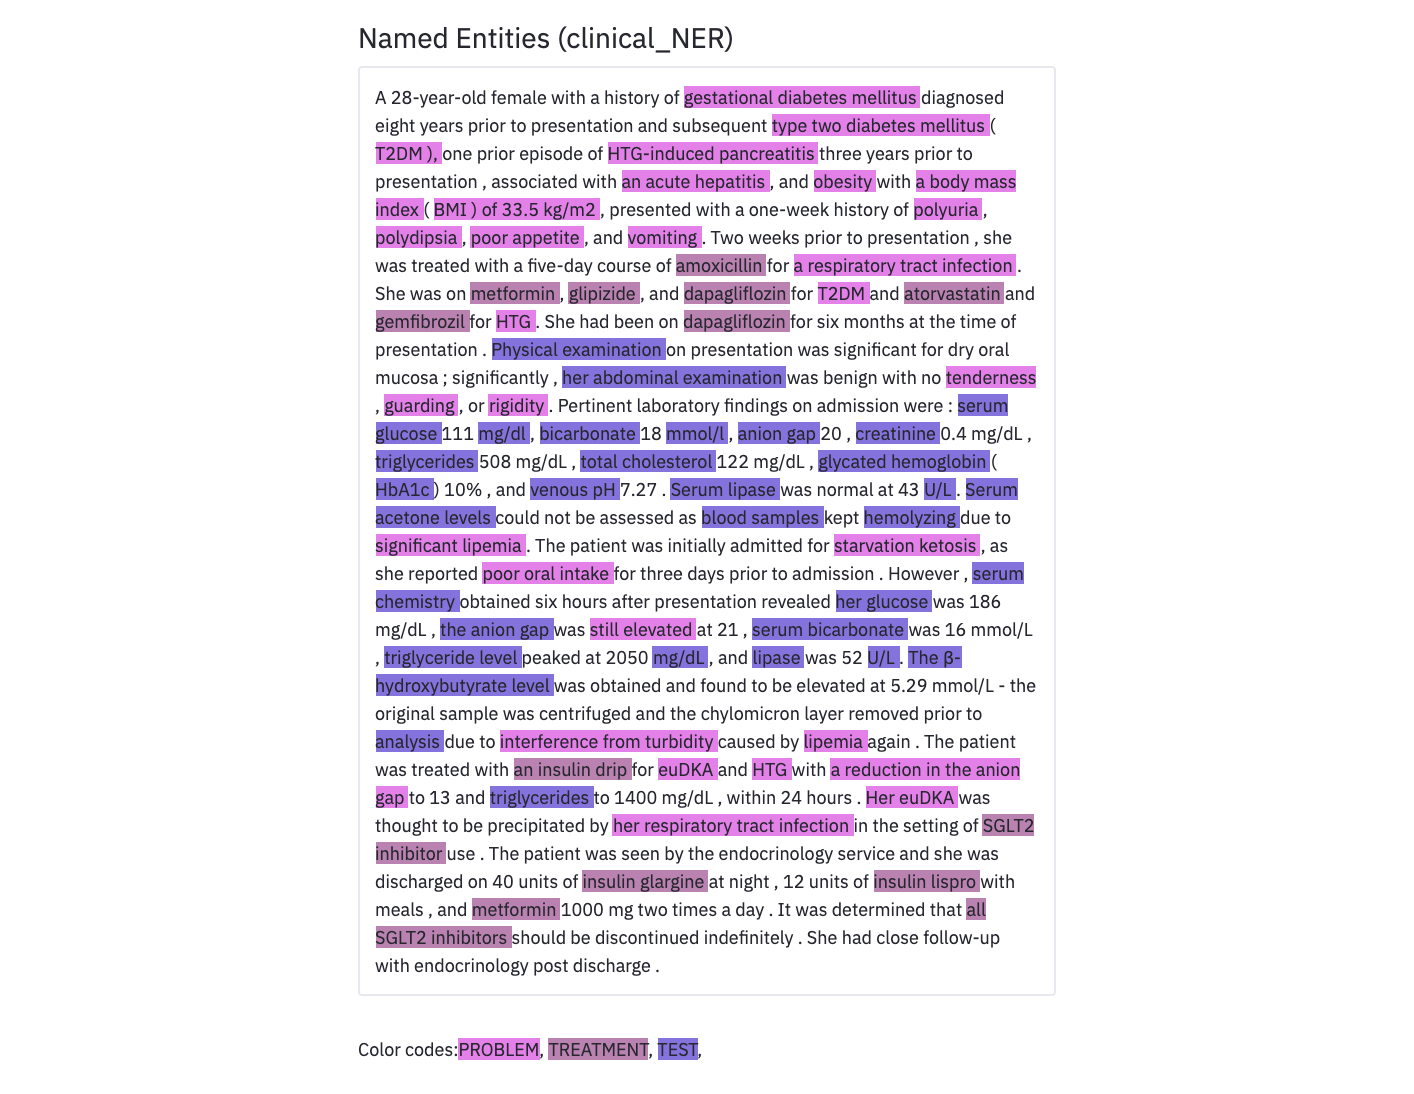

In [ ]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
documentAssembler = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")
        
sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
        .setInputCols(["document"])\
        .setOutputCol("sentence")
 
# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
        .setInputCols(["sentence"])\
        .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical","en","clinical/models")\
        .setInputCols(["sentence","token"])\
        .setOutputCol("embeddings")

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = MedicalNerModel.pretrained("ner_clinical_large","en","clinical/models")\
        .setInputCols(["sentence","token","embeddings"])\
        .setOutputCol("ner")\
        .setLabelCasing("upper") #decide if we want to return the tags in upper or lower case 

ner_converter = NerConverter()\
        .setInputCols(["sentence","token","ner"])\
        .setOutputCol("ner_chunk")

nlpPipeline = Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter])


empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


In [ ]:
model.stages

In [ ]:
clinical_ner.getClasses()

In [ ]:
clinical_ner.extractParamMap()

In [ ]:
clinical_ner.getStorageRef()

In [ ]:
from sparknlp_jsl.compatibility import Compatibility 

In [ ]:
#finding the compatibility of NER model
compatibility = Compatibility(spark) 
compatibility.showVersion('ner_clinical_large')

In [ ]:
#finding the available models and general informations about models by typing key word. 
compatibility.findVersion('ner') 

In [ ]:
# Downloading sample datasets.
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/mt_samples.csv

In [ ]:
import pandas as pd

# mt_samples_df = spark.read.csv("mt_samples.csv", header=True)

mt_samples_df = spark.createDataFrame(pd.read_csv("mt_samples.csv").reset_index())

In [ ]:
mt_samples_df.printSchema()

In [ ]:
mt_samples_df.show()

In [ ]:
print(mt_samples_df.limit(1).collect()[0]['text'])

In [ ]:
result = model.transform(mt_samples_df.limit(100)).cache()

In [ ]:
result.show()

In [ ]:
result.select('token.result','ner.result').show(truncate=100)

In [ ]:
result_df = result.select(F.explode(F.arrays_zip("token.result","ner.result")).alias("cols"))\
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ner_label"))

result_df.show(50, truncate=100)

In [ ]:
result_df.select("token", "ner_label").groupBy('ner_label').count().orderBy('count', ascending=False).show(truncate=False)

In [ ]:
result.select('ner_chunk').take(1)

In [ ]:
result.select(F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata')).alias("cols")) \
.select(F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

### with LightPipelines

In [ ]:
# fullAnnotate in LightPipeline

text = '''
A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely . She had close follow-up with endocrinology post discharge .
'''

print (text)

light_model = LightPipeline(model)

light_result = light_model.fullAnnotate(text)


chunks = []
entities = []
sentence= []
begin = []
end = []

for n in light_result[0]['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence'])
    
    
import pandas as pd

df_clinical = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                   'sentence_id':sentence, 'entities':entities})

df_clinical.head(20)

In [ ]:
light_result[0]

### NER Visualizer

In [ ]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk', document_col='document')

# Change color of an entity label

#visualiser.set_label_colors({'PROBLEM':'#008080', 'TEST':'#800080', 'TREATMENT':'#808080'})
#visualiser.display(light_result[0], label_col='ner_chunk')

# Set label filter

# visualiser.display(light_result[0], label_col='ner_chunk', document_col='document',
                   #labels=['PROBLEM','TEST'])

## NER JSL
Let's show an example of `ner_jsl` model that has about 80 clinical entity labels by changing just only the model name.

**Entities**

| | | | | |
|-|-|-|-|-|
|Injury_or_Poisoning|Direction|Test|Admission_Discharge|Death_Entity|
|Relationship_Status|Duration|Respiration|Hyperlipidemia|Birth_Entity|
|Age|Labour_Delivery|Family_History_Header|BMI|Temperature|
|Alcohol|Kidney_Disease|Oncological|Medical_History_Header|Cerebrovascular_Disease|
|Oxygen_Therapy|O2_Saturation|Psychological_Condition|Heart_Disease|Employment|
|Obesity|Disease_Syndrome_Disorder|Pregnancy|ImagingFindings|Procedure|
|Medical_Device|Race_Ethnicity|Section_Header|Symptom|Treatment|
|Substance|Route|Drug_Ingredient|Blood_Pressure|Diet|
|External_body_part_or_region|LDL|VS_Finding|Allergen|EKG_Findings|
|Imaging_Technique|Triglycerides|RelativeTime|Gender|Pulse|
|Social_History_Header|Substance_Quantity|Diabetes|Modifier|Internal_organ_or_component|
|Clinical_Dept|Form|Drug_BrandName|Strength|Fetus_NewBorn|
|RelativeDate|Height|Test_Result|Sexually_Active_or_Sexual_Orientation|Frequency|
|Time|Weight|Vaccine|Vital_Signs_Header|Communicable_Disease|
|Dosage|Overweight|Hypertension|HDL|Total_Cholesterol|
|Smoking|Date||||

In [ ]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
  .setInputCols(["document"]) \
  .setOutputCol("sentence") 

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("jsl_ner")

jsl_ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "jsl_ner"]) \
  .setOutputCol("jsl_ner_chunk")

jsl_ner_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

jsl_ner_model = jsl_ner_pipeline.fit(empty_data)

In [ ]:
print (text)

jsl_light_model = LightPipeline(jsl_ner_model)

jsl_light_result = jsl_light_model.fullAnnotate(text)


chunks = []
entities = []
sentence= []
begin = []
end = []

for n in jsl_light_result[0]['jsl_ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence'])
    
    
import pandas as pd

jsl_df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                   'sentence_id':sentence, 'entities':entities})

jsl_df.head(20)

### Checking `ner_clinical_large` and `ner_jsl` results together



In [ ]:
from google.colab import widgets

t = widgets.TabBar(["ner_clinical_large", "ner_jsl", "viz_clinical", "viz_jsl"])

with t.output_to(0):
    display(df_clinical)

with t.output_to(1):
    display(jsl_df)

with t.output_to(2):
    visualiser.display(light_result[0], label_col='ner_chunk', document_col='document')

with t.output_to(3):
    visualiser.display(jsl_light_result[0], label_col='jsl_ner_chunk', document_col='document')

## Posology NER
**Entities**

- DOSAGE
- DRUG
- DURATION
- FORM
- FREQUENCY
- ROUTE
- STRENGTH

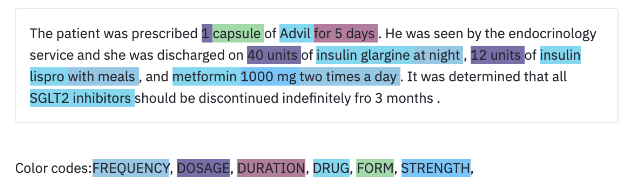

In [ ]:
# NER model trained on i2b2 (sampled from MIMIC) dataset
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

posology_ner_converter = NerConverter()\
        .setInputCols(["sentence","token","ner"])\
        .setOutputCol("ner_chunk")

# greedy model
posology_ner_greedy = MedicalNerModel.pretrained("ner_posology_greedy", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_greedy")

ner_converter_greedy = NerConverter()\
    .setInputCols(["sentence","token","ner_greedy"])\
    .setOutputCol("ner_chunk_greedy")

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    posology_ner_converter,
    posology_ner_greedy,
    ner_converter_greedy])

empty_data = spark.createDataFrame([[""]]).toDF("text")

posology_model = nlpPipeline.fit(empty_data)


In [ ]:
posology_ner.getClasses()

In [ ]:
posology_result = posology_model.transform(mt_samples_df)

In [ ]:
posology_result.show(10)

In [ ]:
posology_result.printSchema()

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# This will return a new DF with all the columns + id
posology_result = posology_result.withColumn("id", monotonically_increasing_id())

posology_result.show(3)

In [ ]:
posology_result.select('token.result','ner.result').show(truncate=100)

In [ ]:
posology_result.select('token.result','ner.result').take(2)

In [ ]:
from pyspark.sql import functions as F

posology_result.select(F.explode(F.arrays_zip('token.result', 'ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ner_label"))\
        .filter("ner_label!='O'")\
        .show(20, truncate=100)


In [ ]:
posology_result.select('id',F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.begin', 'ner_chunk.end', 'ner_chunk.metadata')).alias("cols")) \
.select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
        F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']").alias("begin"),
        F.expr("cols['2']").alias("end"),
        F.expr("cols['3']['entity']").alias("ner_label"))\
        .filter("ner_label!='O'")\
        .show(truncate=False)

In [ ]:
posology_result.select('id',F.explode(F.arrays_zip('ner_chunk_greedy.result', 'ner_chunk_greedy.begin', 'ner_chunk_greedy.end', 'ner_chunk_greedy.metadata')).alias("cols")) \
.select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
        F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']").alias("begin"),
        F.expr("cols['2']").alias("end"),
        F.expr("cols['3']['entity']").alias("ner_label"))\
        .filter("ner_label!='O'")\
        .show(truncate=False)

In [ ]:
posology_result.select('ner_chunk').take(2)[1][0][0].result

In [ ]:
posology_result.select('ner_chunk').take(2)[1][0][0].metadata

In [ ]:
posology_light_model = LightPipeline(posology_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely for 3 months .'

posology_light_result = posology_light_model.annotate(text)

list(zip(posology_light_result['token'], posology_light_result['ner']))

In [ ]:
list(zip(posology_light_result['token'], posology_light_result['ner_greedy']))

In [ ]:
posology_light_result = posology_light_model.fullAnnotate(text)

chunks = []
entities = []
begin =[]
end = []

for n in posology_light_result[0]['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    
import pandas as pd

posology_result_df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                                   'begin': begin, 'end': end})

posology_result_df.head(15)

In [ ]:
chunks = []
entities = []
begin =[]
end = []

for n in posology_light_result[0]['ner_chunk_greedy']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    
import pandas as pd

posology_result_greedy_df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                                          'begin': begin, 'end': end})

posology_result_greedy_df.head(15)

### Comparison of `ner_posology` and `ner_posology_greedy` results

In [ ]:
from google.colab import widgets

t = widgets.TabBar(["ner_posology", "ner_posology_greedy", "viz_posology", "viz_posology_greedy"])

with t.output_to(0):
    display(posology_result_df.head(10))

with t.output_to(1):
    display(posology_result_greedy_df.head(10))

with t.output_to(2):
    visualiser.display(posology_light_result[0], label_col='ner_chunk', document_col='document')

with t.output_to(3):
    visualiser.display(posology_light_result[0], label_col='ner_chunk_greedy', document_col='document')

## Writing a generic NER function

In [ ]:
def get_base_pipeline (embeddings = 'embeddings_clinical'):

  documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

  # Sentence Detector annotator, processes various sentences per line

  sentenceDetector = SentenceDetector()\
      .setInputCols(["document"])\
      .setOutputCol("sentence")

  # Tokenizer splits words in a relevant format for NLP

  tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")

  # Clinical word embeddings trained on PubMED dataset
  word_embeddings = WordEmbeddingsModel.pretrained(embeddings, "en", "clinical/models")\
      .setInputCols(["sentence", "token"])\
      .setOutputCol("embeddings")

  base_pipeline = Pipeline(stages=[
                    documentAssembler,
                    sentenceDetector,
                    tokenizer,
                    word_embeddings
                  ])

  return base_pipeline



def get_clinical_entities (embeddings, spark_df, nrows = 100, model_name = 'ner_clinical'):

  # NER model trained on i2b2 (sampled from MIMIC) dataset
  loaded_ner_model = MedicalNerModel.pretrained(model_name, "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings"]) \
      .setOutputCol("ner")

  ner_converter = NerConverter() \
      .setInputCols(["sentence", "token", "ner"]) \
      .setOutputCol("ner_chunk")

  base_pipeline = get_base_pipeline (embeddings)

  nlpPipeline = Pipeline(stages=[
      base_pipeline,
      loaded_ner_model,
      ner_converter])

  empty_data = spark.createDataFrame([[""]]).toDF("text")

  model = nlpPipeline.fit(empty_data)

  result = model.transform(spark_df.limit(nrows))

  result = result.withColumn("id", monotonically_increasing_id())

  result_df = result.select('id',F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.begin', 'ner_chunk.end', 'ner_chunk.metadata')).alias("cols")) \
                    .select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
                                  F.expr("cols['0']").alias("chunk"),
                                  F.expr("cols['1']").alias("begin"),
                                  F.expr("cols['2']").alias("end"),
                                  F.expr("cols['3']['entity']").alias("ner_label"))\
                                  .filter("ner_label!='O'")

  return result_df

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_clinical'

nrows = 100

ner_df = get_clinical_entities (embeddings, mt_samples_df, nrows, model_name)

ner_df.show()

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_posology'

nrows = 100

ner_df = get_clinical_entities (embeddings, mt_samples_df, nrows, model_name)

ner_df.show()

In [ ]:
import pandas as pd

def get_clinical_entities_light (light_model, text, chunk_name="ner_chunk"):

  light_result = light_model.fullAnnotate(text)

  chunks = []
  entities = []

  for n in light_result[0][chunk_name]:
          
      chunks.append(n.result)
      entities.append(n.metadata['entity']) 
      
  df = pd.DataFrame({'chunks':chunks, 'entities':entities})

  return df

In [ ]:
text ='The patient was prescribed 1 capsule of Parol with meals . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_model = LightPipeline(posology_model)

get_clinical_entities_light (light_model, text)


## PHI NER

**Entities**
- AGE
- CONTACT
- DATE
- ID
- LOCATION
- NAME
- PROFESSION

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_deid_generic_augmented'

# deidentify_dl
# ner_deid_large
# ner_deid_generic_augmented
# ner_deid_subentity_augmented
# ner_deid_subentity_augmented_i2b2

nrows = 100

ner_df = get_clinical_entities (embeddings, mt_samples_df, nrows, model_name)

pd_ner_df = ner_df.toPandas()


In [ ]:
pd_ner_df.sample(20)

In [ ]:
pd_ner_df.ner_label.value_counts()

## BioNLP (Cancer Genetics) NER

**Entities**

| | | |
|-|-|-|
|tissue_structure|Amino_acid|Simple_chemical|
|Organism_substance|Developing_anatomical_structure|Cell|
|Cancer|Cellular_component|Gene_or_gene_product|
|Immaterial_anatomical_entity|Organ|Organism|
|Pathological_formation|Organism_subdivision|Anatomical_system|
|Tissue|||

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_bionlp'

nrows = 100

ner_df = get_clinical_entities (embeddings, mt_samples_df.filter("index == '2'"), nrows, model_name)

ner_df.show(truncate = False)

## NER Chunker
We can extract phrases that fits into a known pattern using the NER tags. NerChunker would be quite handy to extract entity groups with neighboring tokens when there is no pretrained NER model to address certain issues. Lets say we want to extract drug and frequency together as a single chunk even if there are some unwanted tokens between them. 

In [ ]:
cposology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_chunker = NerChunker()\
    .setInputCols(["sentence","ner"])\
    .setOutputCol("ner_chunk")\
    .setRegexParsers(["<DRUG>.*<FREQUENCY>"])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    ner_chunker])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ner_chunker_model = nlpPipeline.fit(empty_data)

In [ ]:
posology_ner.getClasses()

In [ ]:
light_model = LightPipeline(ner_chunker_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_result = light_model.annotate(text)

list(zip(light_result['token'], light_result['ner']))

In [ ]:
light_result["ner_chunk"]

## Chunk Filterer
ChunkFilterer will allow you to filter out named entities by some conditions or predefined look-up lists, so that you can feed these entities to other annotators like Assertion Status or Entity Resolvers. It can be used with two criteria: isin and regex.

In [ ]:
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings"]) \
      .setOutputCol("ner")

ner_converter = NerConverter()\
      .setInputCols(["sentence","token","ner"])\
      .setOutputCol("ner_chunk")
      
chunk_filterer = ChunkFilterer()\
      .setInputCols("sentence","ner_chunk")\
      .setOutputCol("chunk_filtered")\
      .setCriteria("isin")\
      .setWhiteList(['Advil','metformin', 'insulin lispro'])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    ner_converter,
    chunk_filterer])

empty_data = spark.createDataFrame([[""]]).toDF("text")

chunk_filter_model = nlpPipeline.fit(empty_data)

In [ ]:
light_model = LightPipeline(chunk_filter_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_result = light_model.annotate(text)

light_result.keys()

In [ ]:
light_result['ner_chunk'] 

In [ ]:
light_result['chunk_filtered']

In [ ]:
ner_model = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models")\
      .setInputCols("sentence","token","embeddings")\
      .setOutputCol("ner")

ner_converter = NerConverter()\
      .setInputCols(["sentence","token","ner"])\
      .setOutputCol("ner_chunk")
      
chunk_filterer = ChunkFilterer()\
      .setInputCols("sentence","ner_chunk")\
      .setOutputCol("chunk_filtered")\
      .setCriteria("isin")\
      .setWhiteList(['severe fever','sore throat'])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ner_model,
    ner_converter,
    chunk_filterer])

empty_data = spark.createDataFrame([[""]]).toDF("text")

chunk_filter_model = nlpPipeline.fit(empty_data)

In [ ]:
text = 'Patient with severe fever, severe cough, sore throat, stomach pain, and a headache.'

filter_df = spark.createDataFrame([[text]]).toDF("text")

chunk_filter_result = chunk_filter_model.transform(filter_df)

In [ ]:
chunk_filter_result.select('ner_chunk.result','chunk_filtered.result').show(truncate=False)

## Changing entity labels with `NerConverterInternal()`

In [ ]:
replace_dict = """Drug_BrandName, Drug
Frequency, Drug_Frequency
Dosage, Drug_Dosage
Strength, Drug_Strength
"""
with open('replace_dict.csv', 'w') as f:
    f.write(replace_dict)

In [ ]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
  .setInputCols(["document"]) \
  .setOutputCol("sentence") 

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("jsl_ner")

jsl_ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "jsl_ner"]) \
  .setOutputCol("jsl_ner_chunk")

jsl_ner_converter_internal = NerConverterInternal()\
  .setInputCols(["sentence","token","jsl_ner"])\
  .setOutputCol("replaced_ner_chunk")\
  .setReplaceDictResource("replace_dict.csv","text", {"delimiter":","})
      
nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter,
    jsl_ner_converter_internal
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ner_converter_model = nlpPipeline.fit(empty_data)

In [ ]:
text ='The patient was prescribed 1 capsule of Parol with meals . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_model = LightPipeline(ner_converter_model)

jsl_ner_chunk_df = get_clinical_entities_light (light_model, text, chunk_name='jsl_ner_chunk')
replaced_ner_chunk_df = get_clinical_entities_light (light_model, text, chunk_name='replaced_ner_chunk')
pd.concat([jsl_ner_chunk_df, replaced_ner_chunk_df.iloc[:,1:].rename(columns= {'entities':'replaced'})], axis=1)


## Downloading Pretrained Models

- When we use `.pretrained` method, model is downloaded to  a folder named `cache_pretrained` automatically and it is loaded from thit folder if you run it again.

- In order to download the models manually to any folder, you can follow the steps below. In this case you should use `.load()` method.

  - Install AWS CLI to your local computer following the steps [here](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-linux.html) for Linux and [here](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-mac.html) for MacOS.

  - Then configure your AWS credentials.

  - Go to models hub and look for the model you need.

  - Select the model you found and you will see the model card that shows all the details about that model.

  - Hover the Download button on that page and you will see the download link from the S3 bucket. 

  - Just use AWS CLI like follows:

```
!aws s3 cp --region us-east-2 s3://auxdata.johnsnowlabs.com/clinical/models/ner_jsl_en_3.1.0_2.4_1624566960534.zip .
```

## Training a Clinical NER (NCBI Disease Dataset)

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NER_NCBIconlltrain.txt
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NER_NCBIconlltest.txt

In [ ]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'NER_NCBIconlltrain.txt')

conll_data.show(3)

In [ ]:
conll_data.count()

In [ ]:
from pyspark.sql import functions as F

conll_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(100,truncate=False)

In [ ]:
conll_data.select("label.result").distinct().count()

In [ ]:
import pyspark.sql.functions as F

#conll_data.select(F.countDistinct("label.result")).show()
#conll_data.groupBy("label.result").count().show(truncate=False)

conll_data = conll_data.withColumn('unique', F.array_distinct("label.result"))\
                       .withColumn('c', F.size('unique'))\
                       .filter(F.col('c')>1)

conll_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(100,truncate=False)

In [ ]:
# Clinical word embeddings trained on PubMED dataset
clinical_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

In [ ]:
test_data = CoNLL().readDataset(spark, 'NER_NCBIconlltest.txt')

test_data = clinical_embeddings.transform(test_data)

test_data.write.parquet('NER_NCBIconlltest.parquet')

### NERDL Graph
TensorFlow graph file (`.pb` extension) should be produced for NER training.

In [ ]:
!pip install -q tensorflow-addons

In [ ]:
from sparknlp_jsl.training import tf_graph
tf_graph.print_model_params("ner_dl")

tf_graph.build("ner_dl", 
               build_params={"embeddings_dim": 200, 
                             "nchars": 83, 
                             "ntags": 12, 
                             "is_medical": 1}, 
               model_location="./medical_ner_graphs", 
               model_filename="auto")

In [ ]:
# for open source users
'''
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/create_graph.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/dataset_encoder.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model_saver.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/sentence_grouper.py

!pip -q install tensorflow==1.15.0

import create_graph

ntags = 3 # number of labels
embeddings_dim = 200
nchars =83

create_graph.create_graph(ntags, embeddings_dim, nchars)
'''

In [ ]:
nerTagger = MedicalNerApproach()\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setLabelColumn("label")\
      .setOutputCol("ner")\
      .setMaxEpochs(5)\
      .setBatchSize(64)\
      .setRandomSeed(0)\
      .setVerbose(1)\
      .setValidationSplit(0.2)\
      .setEvaluationLogExtended(True) \
      .setEnableOutputLogs(True)\
      .setIncludeConfidence(True)\
      .setOutputLogsPath('ner_logs')\
      .setGraphFolder('medical_ner_graphs')\
      .setTestDataset("NER_NCBIconlltest.parquet")\
      .setEnableMemoryOptimizer(True) #>> if you have a limited memory and a large conll file, you can set this True to train batch by batch       

ner_pipeline = Pipeline(stages=[
          clinical_embeddings,
          nerTagger
 ])

In [ ]:
%%time
# 5 epochs around 5 min
ner_model = ner_pipeline.fit(conll_data)

# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook in public folder to create a graph
# licensed users can also use 17.Graph_builder_for_DL_models.ipynb to create tf graphs easily.

`getTrainingClassDistribution()` parameter returns the distribution of labels used when training the NER model.

In [ ]:
ner_model.stages[1].getTrainingClassDistribution()

Let's check the results saved in the log file.

In [ ]:
import os 
log_file= os.listdir("ner_logs")[0]

with open (f"./ner_logs/{log_file}") as f:
  print(f.read())

### Evaluate your model

In [ ]:
pred_df = ner_model.stages[1].transform(test_data)

In [ ]:
pred_df.columns

In [ ]:
from sparknlp_jsl.eval import NerDLMetrics
import pyspark.sql.functions as F

evaler = NerDLMetrics(mode="full_chunk", dropO=True)

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
    .withColumn("recall", F.round(eval_result["recall"],4))\
    .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

In [ ]:
evaler = NerDLMetrics(mode="partial_chunk_per_token", dropO=True)

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
    .withColumn("recall", F.round(eval_result["recall"],4))\
    .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

In [ ]:
ner_model.stages[1].write().overwrite().save('models/custom_NER_5epoch')

In [ ]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

loaded_ner_model = MedicalNerModel.load("models/custom_NER_5epoch")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = NerConverter()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        clinical_embeddings,
        loaded_ner_model,
        converter])

empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [ ]:
text = "She has a metastatic breast cancer to her lungs"

def get_preds(text, light_model):

    result = light_model.fullAnnotate(text)[0]

    return [(i.result, i.metadata['entity']) for i in result['ner_span']]

get_preds(text, light_model)

## BertForTokenClassification NER models

In [ ]:
documentAssembler = DocumentAssembler()\
       .setInputCol("text")\
       .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
       .setInputCols(["document"])\
       .setOutputCol("sentence")

tokenizer = Tokenizer()\
       .setInputCols("sentence")\
       .setOutputCol("token")

tokenClassifier = MedicalBertForTokenClassifier.pretrained("bert_token_classifier_ner_clinical", "en", "clinical/models")\
       .setInputCols("token", "sentence")\
       .setOutputCol("ner")\
       .setCaseSensitive(True)
  
ner_converter = NerConverter()\
       .setInputCols(["sentence","token","ner"])\
       .setOutputCol("ner_chunk")

pipeline =  Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        tokenClassifier,
        ner_converter
        ])

model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

text = """A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . 
Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . 
She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . 
She had been on dapagliflozin for six months at the time of presentation . 
Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . 
Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . 
Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . 
The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . 
However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . 
The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . 
The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . 
Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . 
The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . 
It was determined that all SGLT2 inhibitors should be discontinued indefinitely . 
She had close follow-up with endocrinology post discharge ."""

res = model.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
from pyspark.sql import functions as F

res.select(F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.begin', 'ner_chunk.end', 'ner_chunk.metadata')).alias("cols")) \
.select(F.expr("cols['3']['sentence']").alias("sentence_id"),
        F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']").alias("begin"),
        F.expr("cols['2']").alias("end"),
        F.expr("cols['3']['entity']").alias("ner_label"))\
        .filter("ner_label!='O'")\
        .show(truncate=False)

In [ ]:
light_model = LightPipeline(model)

light_result = light_model.fullAnnotate(text)

from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk', document_col='document')

**Training Clinical BertForTokenClassification Model**

For training own BertForTokenClassification NER model, you can check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.6.BertForTokenClassification_NER_SparkNLP_with_Transformers.ipynb)

## Pretrained NER Profiling Pipelines

We can use pretrained NER profiling pipelines for exploring all the available pretrained NER models at once. In Spark NLP we have two different NER profiling pipelines;

- `ner_profiling_clinical` : Returns results for clinical NER models trained with `embeddings_clinical`.
- `ner_profiling_biobert` : Returns results for clinical NER models trained with `biobert_pubmed_base_cased`.

For more examples, please check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.2.Pretrained_NER_Profiling_Pipelines.ipynb).





**`ner_profiling_clinical` Model List**

|   index | model                             |   index | model                        |   index | model                          |   index | model                           |
|--------:|:----------------------------------|--------:|:-----------------------------|--------:|:-------------------------------|--------:|:--------------------------------|
|       1 | ner_ade_clinical                  |      13 | nerdl_tumour_demo            |      25 | ner_drugs                      |      37 | ner_radiology_wip_clinical      |
|       2 | ner_posology_greedy               |      14 | ner_deid_subentity_augmented |      26 | ner_deid_sd                    |      38 | ner_clinical                    |
|       3 | ner_risk_factors                  |      15 | ner_jsl_enriched             |      27 | ner_posology_large             |      39 | ner_chemicals                   |
|       4 | jsl_ner_wip_clinical              |      16 | ner_genetic_variants         |      28 | ner_deid_large                 |      40 | ner_deid_synthetic              |
|       5 | ner_human_phenotype_gene_clinical |      17 | ner_bionlp                   |      29 | ner_posology                   |      41 | ner_events_clinical             |
|       6 | jsl_ner_wip_greedy_clinical       |      18 | ner_measurements_clinical    |      30 | ner_deidentify_dl              |      42 | ner_posology_small              |
|       7 | ner_cellular                      |      19 | ner_diseases_large           |      31 | ner_deid_enriched              |      43 | ner_anatomy_coarse              |
|       8 | ner_cancer_genetics               |      20 | ner_radiology                |      32 | ner_bacterial_species          |      44 | ner_human_phenotype_go_clinical |
|       9 | jsl_ner_wip_modifier_clinical     |      21 | ner_deid_augmented           |      33 | ner_drugs_large                |      45 | ner_jsl_slim                    |
|      10 | ner_drugs_greedy                  |      22 | ner_anatomy                  |      34 | ner_clinical_large             |      46 | ner_jsl                         |
|      11 | ner_deid_sd_large                 |      23 | ner_chemprot_clinical        |      35 | jsl_rd_ner_wip_greedy_clinical |      47 | ner_jsl_greedy                  |
|      12 | ner_diseases                      |      24 | ner_posology_experimental    |      36 | ner_medmentions_coarse         |      48 | ner_events_admission_clinical   |

**`ner_profiling_BERT` Model List**



|   index | model                  |   index | model                            |   index | model                         |
|--------:|:-----------------------|--------:|:---------------------------------|--------:|:------------------------------|
|       1 | ner_cellular_biobert   |       8 | ner_jsl_enriched_biobert         |      15 | ner_posology_large_biobert    |
|       2 | ner_diseases_biobert   |       9 | ner_human_phenotype_go_biobert   |      16 | jsl_rd_ner_wip_greedy_biobert |
|       3 | ner_events_biobert     |      10 | ner_deid_biobert                 |      17 | ner_posology_biobert          |
|       4 | ner_bionlp_biobert     |      11 | ner_deid_enriched_biobert        |      18 | jsl_ner_wip_greedy_biobert    |
|       5 | ner_jsl_greedy_biobert |      12 | ner_clinical_biobert             |      19 | ner_chemprot_biobert          |
|       6 | ner_jsl_biobert        |      13 | ner_anatomy_coarse_biobert       |      20 | ner_ade_biobert               |
|       7 | ner_anatomy_biobert    |      14 | ner_human_phenotype_gene_biobert |      21 | ner_risk_factors_biobert      |

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

clinical_profiling_pipeline = PretrainedPipeline("ner_profiling_clinical", "en", "clinical/models")

In [ ]:
text = '''A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting .'''

In [ ]:
clinical_result = clinical_profiling_pipeline.fullAnnotate(text)[0]
clinical_result.keys()

In [ ]:
import pandas as pd

def get_token_results(light_result):

  tokens = [j.result for j in light_result["token"]]
  sentences = [j.metadata["sentence"] for j in light_result["token"]]
  begins = [j.begin for j in light_result["token"]]
  ends = [j.end for j in light_result["token"]]
  model_list = [ a for a in light_result.keys() if (a not in ["sentence", "token"] and "_chunks" not in a)]

  df = pd.DataFrame({'sentence':sentences, 'begin': begins, 'end': ends, 'token':tokens})

  for model_name in model_list:
    
    temp_df = pd.DataFrame(light_result[model_name])
    temp_df["jsl_label"] = temp_df.iloc[:,0].apply(lambda x : x.result)
    temp_df = temp_df[["jsl_label"]]

    # temp_df = get_ner_result(model_name)
    temp_df.columns = [model_name]
    df = pd.concat([df, temp_df], axis=1)
    
  return df

In [ ]:
get_token_results(clinical_result)

## NER Model Finder Pretrained Pipeline
`ner_model_finder`  pretrained pipeline trained with bert embeddings that can be used to find the most appropriate NER model given the entity name.

In [ ]:
from sparknlp.pretrained import PretrainedPipeline
finder_pipeline = PretrainedPipeline("ner_model_finder", "en", "clinical/models")

In [ ]:
result = finder_pipeline.fullAnnotate("oncology")[0]
result.keys()

From the metadata in the `model_names` column, we'll get to the top models to the given 'oncology' entity and oncology related categories.

In [ ]:
df= pd.DataFrame(zip(result["model_names"][0].metadata["all_k_resolutions"].split(":::"), 
                     result["model_names"][0].metadata["all_k_results"].split(":::")), columns=["category", "top_models"])

In [ ]:
df.head()